# Post Treatment Bias Example

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Generate Data

In [2]:
samples = 100
height_0 = np.random.normal(10, 2.5, samples)
treatment = np.repeat([0,1], samples/2)
fungus = np.random.binomial(1, p = 0.65- 0.4*treatment, size=samples)
height_1 = height_0 + np.random.normal(5 - 2*fungus, 1)
p_growth = height_1/height_0

data = pd.DataFrame({"height_0":height_0, "treatment":treatment, "fungus":fungus, "height_1":height_1, "p_growth": p_growth})


In [3]:
np.sum(fungus)

40

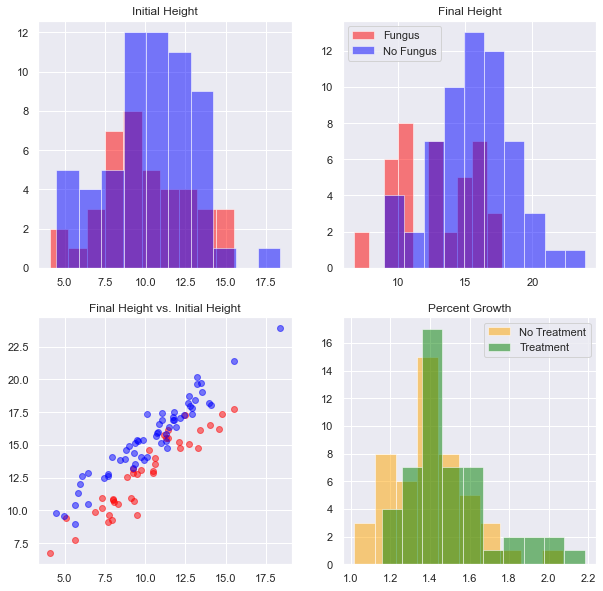

In [4]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].hist(x=data[data["fungus"] == 1]["height_0"], color="red", alpha=0.5, bins=10, label="Fungus")
ax[0,0].hist(x=data[data["fungus"] == 0]["height_0"], color="blue", alpha=0.5, bins=10, label="No Fungus")
ax[0,0].set_title("Initial Height")

ax[0,1].hist(x=data[data["fungus"] == 1]["height_1"], color="red", alpha=0.5, bins=10, label="Fungus")
ax[0,1].hist(x=data[data["fungus"] == 0]["height_1"], color="blue", alpha=0.5, bins=10, label="No Fungus")
ax[0,1].set_title("Final Height")
ax[0,1].legend()

ax[1,0].scatter(x=data[data["fungus"] == 1]["height_0"], y=data[data["fungus"] == 1]["height_1"], color="red", alpha=0.5)
ax[1,0].scatter(x=data[data["fungus"] == 0]["height_0"], y=data[data["fungus"] == 0]["height_1"], color="blue", alpha=0.5)
ax[1,0].set_title("Final Height vs. Initial Height")

ax[1,1].hist(x=data[data["treatment"] == 0]["p_growth"], color="orange", alpha=0.5, bins=10, label="No Treatment")
ax[1,1].hist(x=data[data["treatment"] == 1]["p_growth"], color="green", alpha=0.5, bins=10, label="Treatment")
ax[1,1].set_title("Percent Growth")
ax[1,1].legend()

Specify the model

In [5]:
with pm.Model() as m_plant:

    H0 = pm.Data("H0", height_0)
    T = pm.Data("T", treatment)
    H1 = pm.Data("H1", height_1)

    alpha = pm.Lognormal("alpha", mu=0, sd=1/2)
    beta_T = pm.Normal("beta_T", mu=0, sd=1/4)
    sigma = pm.Exponential("sigma", 1)
    
    p = alpha + beta_T * T

    obs = pm.Normal("obs", mu=p*H0, sigma=sigma, observed=H1)

Check the priors

Text(0.5, 1.0, 'Prior Predictive Distribution of Percent Growth')

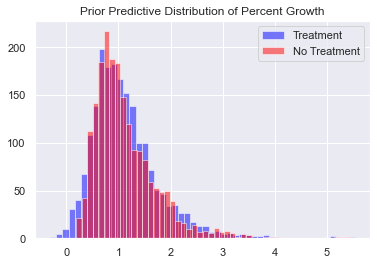

In [6]:
with m_plant:
    priors = pm.sample_prior_predictive(samples=2000)

plt.hist(priors["alpha"] + priors["beta_T"], alpha=0.5, bins=50, color="blue", label="Treatment")
plt.hist(priors["alpha"], alpha=0.5, bins=50, color="red", label="No Treatment")
plt.legend()
plt.title("Prior Predictive Distribution of Percent Growth")

Generate posterior distributions

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_3382/766763842.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_plant = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_T, alpha]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8806671398243097, but should be close to 0.8. Try to increase the number of tuning steps.


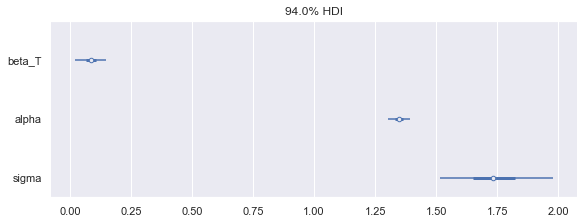

In [7]:
with m_plant:
    trace_plant = pm.sample()
    # pm.plot_trace(trace_plant)
    pm.plot_forest(trace_plant, combined=True, figsize=(8,3))

Model the fungus effect - this is technically incorrect because the way the study was done.

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_3382/2447621746.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_plant_f = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_F, beta_T, alpha]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.wa

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8826488507229128, but should be close to 0.8. Try to increase the number of tuning steps.


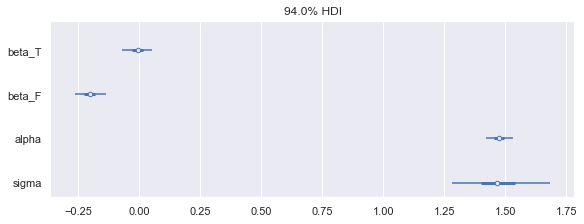

In [8]:
with pm.Model() as m_plant_f:

    H0 = pm.Data("H0", height_0)
    T = pm.Data("T", treatment)
    F = pm.Data("F", fungus)
    H1 = pm.Data("H1", height_1)

    alpha = pm.Lognormal("alpha", mu=0, sd=1/2)
    beta_T = pm.Normal("beta_T", mu=0, sd=1/4)
    beta_F = pm.Normal("beta_F", mu=0, sd=1/4)
    sigma = pm.Exponential("sigma", 1)
    
    p = alpha + beta_T * T + beta_F * F

    obs = pm.Normal("obs", mu=p*H0, sigma=sigma, observed=H1)

with m_plant_f:
    trace_plant_f = pm.sample()
    # pm.plot_trace(trace_plant)
    pm.plot_forest(trace_plant_f, combined=True, figsize=(8,3))

Forest plot of effects of Treatment and Fungus for each.

The effect of treatment is almost non-existent if we include the observed presence of fungus post trial, leading us to conclude that treatment may not actually help plant growth.

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

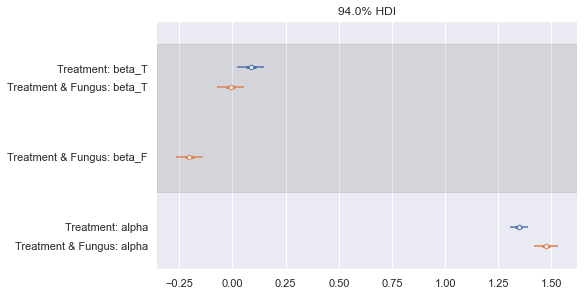

In [9]:
pm.plot_forest(
    data=[trace_plant, trace_plant_f],
    model_names=["Treatment", "Treatment & Fungus"],
    var_names=["beta_T", "beta_F", "alpha"],
    combined=True,
    figsize=(8,4)
)